## Strongly advise to use GPU to train this model
  

In [8]:
from PIL import Image
import zipfile
import xml.etree.ElementTree as ET
from io import BytesIO
from tqdm import tqdm
import re

import cv2
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [24]:
TARGET_SIZE_IM = (256,256)
batch_size = 64

In [9]:
## Create a food dictionnary to match the category number to the food brand
food_dict_num_brand = {}

zip_file_path = '/content/drive/MyDrive/Capstone Project/Data/FoodLogoDet-1500.zip'
text_file_name = 'FoodLogoDet-1500/food.txt'

def create_dicts(zip_file_path, text_file_name):
  with zipfile.ZipFile(zip_file_path, 'r') as z:
    with z.open(text_file_name) as file:
      for line in file:
        line = line.strip()
        line = line.decode('utf-8').strip()
        if line:  # Check if the line is not empty
          value, key = line.split(':')
          # Remove the digit at the end of the brand that highlights the specific version of the logo
          # if '-' in value and value.rsplit('-', 1)[-1].isdigit():
          #     value = value.rsplit('-', 1)[0]
          food_dict_num_brand[key] = value
  return food_dict_num_brand

# Create the dict that makes the correspondence between a brand name and a number
food_dict_num_brand = create_dicts(zip_file_path, text_file_name)
food_dict_brand_num = {name: number for number, name in food_dict_num_brand.items()}

print(list(food_dict_num_brand.keys())[10], ':', list(food_dict_num_brand.values())[10])
print(f'There are {len(food_dict_num_brand)} different brands')

11 : Aalst-1
There are 1500 different brands


In [12]:
## Create a pandas dataset to do the EDA
zip_file_path = '/content/drive/MyDrive/Capstone Project/Data/FoodLogoDet-1500.zip'
annotation_folder = 'FoodLogoDet-1500/Annotations/'


data = []

# Function to extract the base brand name (no digit at the end)
def extract_brand(category):
    if pd.isna(category):
        return None
    # Use regex to match 'brand names' followed by optional '-number'
    match = re.match(r'^(.*?)(?:-\d+)?$', category)
    return match.group(1) if match else category

with zipfile.ZipFile(zip_file_path, 'r') as z:
    files_in_zip = z.namelist()

    # Find the path to all the .xml files
    annotation_files = [f for f in files_in_zip if f.startswith(annotation_folder) and f.endswith('.xml')]
    for xml_file in annotation_files:
        with z.open(xml_file) as file:
            xml_content = file.read()
            root = ET.fromstring(xml_content)

            image_name = xml_file.split('/')[-1].split('.')[0]
            nb_object = len(root.findall('object'))
            for obj in root.findall('object'):
                category = food_dict_num_brand[obj.find('name').text]
                trunc = obj.find('truncated').text
                brand = extract_brand(category)
                data.append({'filename': image_name,
                             'num_objects': nb_object,
                             'category': category,
                             'truncated': trunc,
                             'brand': brand})

df = pd.DataFrame(data)
print('number of product:', len(df))
df.head()

number of product: 145400


,filename,num_objects,category,truncated,brand
0,000001,1,Arizmendi Bakery,0,Arizmendi Bakery
1,000002,2,Anglo Bubbly,0,Anglo Bubbly
2,000002,2,Anglo Bubbly,0,Anglo Bubbly
3,000003,1,toblerone,0,toblerone
4,000004,2,vikingfjord,0,vikingfjord


In [13]:
'''After Having a look at the pictures and the names of the brands associated, I noted that there are 4 pictures
where there are apparently 2 brands on the picture where actually I only see one. So I decided to remove from the dataset
the row with the other brand that I don't see.'''
def remove_unwanted_discepancies(df):
    # Step 1: Identify discrepancies
    discrepancies = df.groupby('filename')['brand'].nunique()
    filenames_with_discrepancies = discrepancies[discrepancies > 1].index.tolist()
    if filenames_with_discrepancies:
        for filename in filenames_with_discrepancies:
            brands = df[df['filename'] == filename]['brand'].unique()
            print(f"Filename: {filename} has the following brands: {brands}")

    # Step 2: Create a DataFrame with rows from the original DataFrame that have these filenames
    discrepancy_rows = df[df['filename'].isin(filenames_with_discrepancies)]

    # Step 3: Keep only the rows where brand is 'Buddy Fruits' instead of 'Boon Rawd Brewery'
    buddy_fruit_rows = discrepancy_rows[discrepancy_rows['brand'] == 'Buddy Fruits']

    # Step 4: Combine with the rest of the original DataFrame (keeping only unique filenames)
    remaining_rows = df[~df['filename'].isin(filenames_with_discrepancies)]
    final_df = pd.concat([remaining_rows, buddy_fruit_rows]).reset_index(drop=True)
    return final_df

# print(f"Total rows in the original DataFrame: {len(df)}")
# df = remove_unwanted_discepancies(df)
# print(f"Total rows in the final DataFrame: {len(df)}")
# print(df[df['filename'] == '070411'])

In [17]:
## Create the list with labels for all images
def get_labels(df, col, mapping_dict):
  unique_rows = df.drop_duplicates(subset='filename')
  annotations = unique_rows.reset_index(drop=True)
  annotations[col].nunique()

  labels = annotations[col].map(mapping_dict).values.astype(float)
  labels = labels - 1  # This line adjusts the labels to be zero-based
  labels = to_categorical(labels, num_classes=len(mapping_dict)) # Convert to one-hot encoding
  return labels

labels = get_labels(df, 'category', food_dict_brand_num)
print(labels.shape)

(99768, 1500)


In [22]:
def resize_with_padding(img_data, target_size=TARGET_SIZE_IM):
    """Resize an image while maintaining its aspect ratio and padding to fit the target size.

    Inputs:
    - img_data: array of dimensions at least 2, usually having a third dimension for the color
    - traget_size: tuple (height, width)
    """
    old_size = img_data.shape[:2]
    ratio = float(target_size[0]) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])

    # Resize the image
    image = cv2.resize(img_data, (new_size[1], new_size[0]))

    # Padding to match target size
    delta_w = target_size[1] - new_size[1]
    delta_h = target_size[0] - new_size[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    color = [0, 0, 0]  # Padding color (black)
    new_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return new_image

In [23]:
## Generate the dataset with batches of images
zip_file_path = '/content/drive/MyDrive/Capstone Project/Data/FoodLogoDet-1500.zip'
image_folder = 'FoodLogoDet-1500/JPEGImages/'

with zipfile.ZipFile(zip_file_path, 'r') as z:
    files_in_zip = z.namelist()
    image_files = [f for f in files_in_zip if f.startswith(image_folder) and f.endswith('.jpg')]

# Create a list with the index for the train set and the validation set
image_indices = np.arange(len(image_files))
train_indices, val_indices = train_test_split(image_indices, test_size=0.2, random_state=42)

def image_data_generator(zip_file_path, image_files, indices, labels, batch_size=32, target_size=TARGET_SIZE_IM):
    """Yield batches of images and labels from a zip file using indices.

    Inputs:
    - zip_file_path: the path to the zip file that contains the images
    - image_files: list with the path inside the zip folder for each image
    - indices: indices of the image that will be used in this dataset
    - labels: np.array with the lables for the images
    - batch_size: size of the batch
    - target_size: size of the images (height, width)
    """
    with zipfile.ZipFile(zip_file_path, 'r') as z:
        while True:
            for start in range(0, len(indices), batch_size):
                end = min(start + batch_size, len(indices))
                batch_images = []
                batch_labels = []

                for i in range(start, end):
                    index = indices[i]  # Use the index to get the image filename and label
                    try:
                        with z.open(image_files[index]) as img_file:
                            img = Image.open(BytesIO(img_file.read()))
                            img_data = np.array(img.convert('RGB'))
                            image = resize_with_padding(img_data, target_size)
                        batch_images.append(image)
                        batch_labels.append(labels[index])  # Map index to label
                    except OSError as e:
                        print(f"Warning: Could not process image {image_files[index]}. Error: {e}")

                batch_images = np.array(batch_images)
                batch_labels = np.array(batch_labels)

                yield batch_images, batch_labels



In [25]:
# Create the training and validation datasets using indices
train_dataset = tf.data.Dataset.from_generator(
    lambda: image_data_generator(zip_file_path, image_files, train_indices, labels, batch_size),
    output_signature=(
        tf.TensorSpec(shape=(None, TARGET_SIZE_IM[0], TARGET_SIZE_IM[1], 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(food_dict_brand_num)), dtype=tf.float32)
    )
).prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: image_data_generator(zip_file_path, image_files, val_indices, labels, batch_size),
    output_signature=(
        tf.TensorSpec(shape=(None, TARGET_SIZE_IM[0], TARGET_SIZE_IM[1], 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(food_dict_brand_num)), dtype=tf.float32)
    )
).prefetch(tf.data.experimental.AUTOTUNE)

In [21]:
## Create the architecture of the model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(TARGET_SIZE_IM[0], TARGET_SIZE_IM[1], 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(len(food_dict_brand_num), activation='softmax'))  # Output layer for multi-class classification

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1500)                │         769,500 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,855,900 (52.86 MB)

 Trainable params: 13,855,900 (52.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(train_indices) // batch_size,
    epochs=20,
    validation_data=val_dataset,
    validation_steps=len(val_indices) // batch_size
)

In [ ]:
model.fit(
    dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=5
)

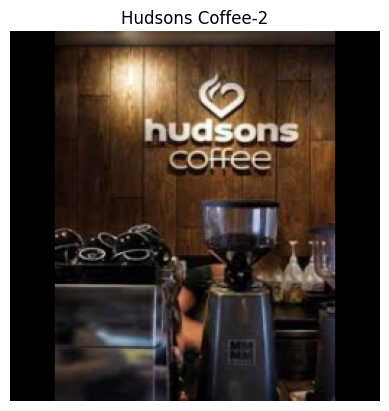

In [ ]:
## Test the data generator

gen = image_data_generator(zip_file_path, image_folder, labels, batch_size=32)

# Fetch a single batch
try:
    images, lbls = next(gen)
    print(f"Fetched batch - Images shape: {images.shape}, Labels shape: {lbls.shape}")
except StopIteration:
    print("The generator has no data.")

def get_brand_name(idx):
    indices = np.where(lbls[idx] == 1)[0]  # Get indices where label is 1
    brands = [food_dict_num_brand.get(str(i + 1)) for i in indices]  # Get brand names
    return brands

# Select an index
idx = 20
brand = get_brand_name(idx)

# Display the image
plt.imshow(images[idx])
plt.axis('off')  # Optional: Hide axes for better visualization
plt.title(f'{brand[0]}')
plt.show()

  TO BE DONE: Think about how to deal with the brands which has 2 different logo -> keep one name of make the different + buddy fruits pictures ...